In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
from historical_data import get_historical_prices_for_two_assets
from datetime import datetime
from experiments.experiment import HistoricalDataDescription, Experiment, UninformedUsersConfig
from user.informed_user import InformedUser
from user.uninformed_user import UninformedUser
from fee_algorithm.fixed_fee import FixedFee

experiment = Experiment(
    data=HistoricalDataDescription(
        stable_coin_symbol="USDT",
        A_symbol="ETH",
        B_symbol="BTC",
        candle_interval="5m",
        start_time=datetime(2024, 11, 1, 12, 0, 0),
        end_time=datetime(2024, 11, 10, 12, 0, 0),
    ),
    informed_user=InformedUser(),
    uninformed_users=UninformedUsersConfig(
        uninformed_user=UninformedUser(),
        probability_of_trade=0.5,
        n_users=1,
    ),
    fee_algorithm=FixedFee(0.0001),
)

In [3]:
import numpy as np
from experiments.run_experiment import run_experiment

np.random.seed(0)

experiment_result = run_experiment(experiment)
simulation_result = experiment_result.simulation_result

In [4]:
simulation_result.snapshots[-1]

SimulationStateSnapshot(user_states={<UserType.INFORMED: 1>: ParticipantState(total_markout=np.float64(8859.688556370207), trades_count=665, position=Position(position_a=np.float64(307.94542158318666), position_b=np.float64(-11.685423288707078)), valuation=np.float64(56041.16187879734)), <UserType.UNINFORMED: 2>: ParticipantState(total_markout=np.float64(-7192.409723009172), trades_count=1299, position=Position(position_a=np.float64(-38.447658096056784), position_b=np.float64(1.412888564875974)), valuation=np.float64(-10660.670658409028))}, lp_state=ParticipantState(total_markout=np.float64(-11487.278833361028), trades_count=1964, position=Position(position_a=np.float64(4693.281392840427), position_b=np.float64(188.8703957786959)), valuation=np.float64(30042660.57609974)), lp_with_just_hold_strategy=ParticipantState(total_markout=0, trades_count=0, position=Position(position_a=np.float64(4962.779156327543), position_b=np.float64(178.5978610548647)), valuation=np.float64(30088041.067320

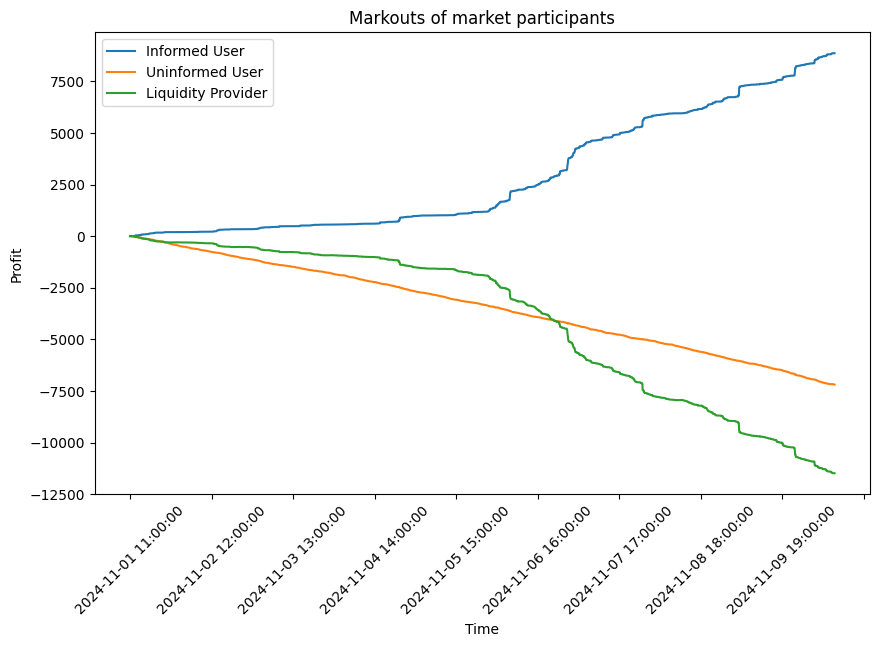

In [5]:
# Plot all participants' profits
import seaborn as sns
import matplotlib.pyplot as plt
from simulation.simulation import UserType, SimulationResult
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(10, 6))

def extract_user_markouts(
    simulation_result: SimulationResult, user_type: UserType
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.user_states[user_type].total_markout)
    return res
        
def extract_lp_markouts(simulation_result: SimulationResult) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.lp_state.total_markout)
    return res

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_markouts(simulation_result, UserType.INFORMED),
    ax=ax,
    label="Informed User",
)

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_markouts(simulation_result, UserType.UNINFORMED),
    ax=ax,
    label="Uninformed User",
)


sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_lp_markouts(simulation_result),
    ax=ax,
    label="Liquidity Provider",
)

ax.xaxis.set_major_locator(
    MaxNLocator(nbins=10)
)  # Set to show a maximum of 10 ticks

plt.xlabel("Time")
plt.ylabel("Profit")

plt.xticks(rotation=45)

plt.title("Markouts of market participants")

plt.show()

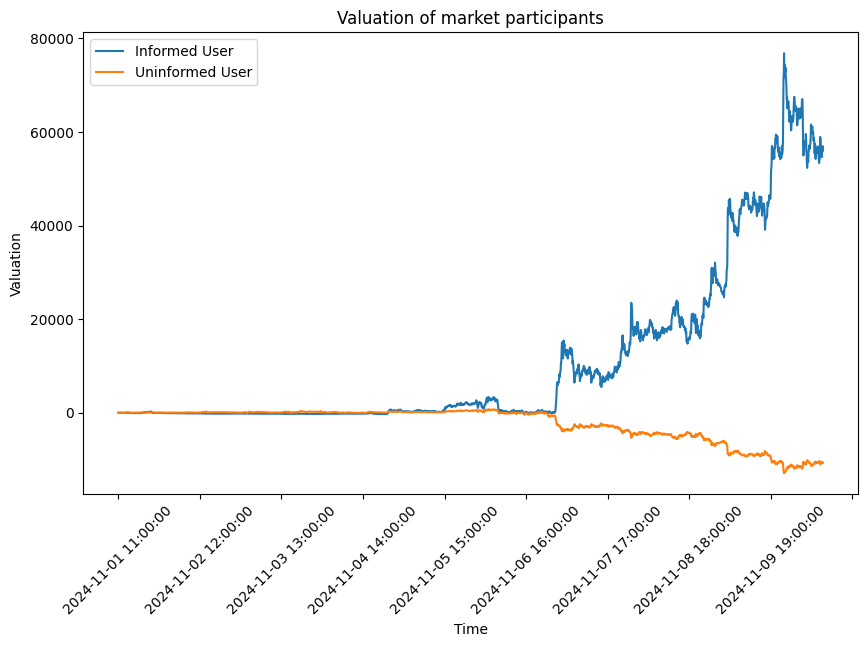

In [6]:
def extract_user_valuations(
    simulation_result: SimulationResult, user_type: UserType
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.user_states[user_type].valuation)
    return res
        

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_valuations(simulation_result, UserType.INFORMED),
    ax=ax,
    label="Informed User",
)

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_valuations(simulation_result, UserType.UNINFORMED),
    ax=ax,
    label="Uninformed User",
)

ax.xaxis.set_major_locator(
    MaxNLocator(nbins=10)
)  # Set to show a maximum of 10 ticks

plt.xlabel("Time")
plt.ylabel("Valuation")


plt.xticks(rotation=45)

plt.title("Valuation of market participants")

plt.show()

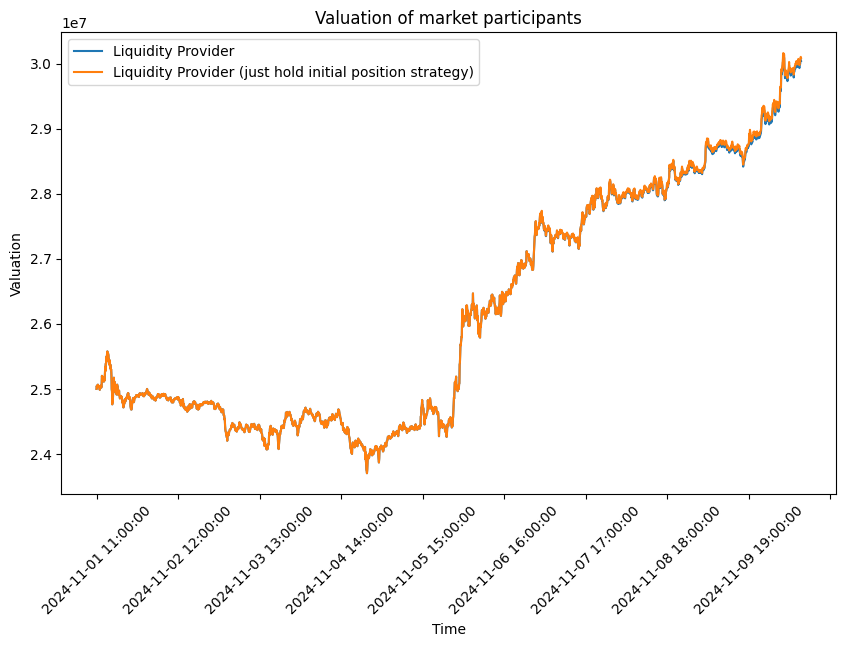

In [7]:
def extract_lp_valuations(
    simulation_result: SimulationResult
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.lp_state.valuation)
    return res

def extract_lp_only_hold_valuations(
    simulation_result: SimulationResult
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.lp_with_just_hold_strategy.valuation)
    return res

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_lp_valuations(simulation_result),
    ax=ax,
    label="Liquidity Provider",
)

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_lp_only_hold_valuations(simulation_result),
    ax=ax,
    label="Liquidity Provider (just hold initial position strategy)",
)

ax.xaxis.set_major_locator(
    MaxNLocator(nbins=10)
)  # Set to show a maximum of 10 ticks

plt.xlabel("Time")
plt.ylabel("Valuation")

plt.xticks(rotation=45)

plt.title("Valuation of market participants")

plt.show()

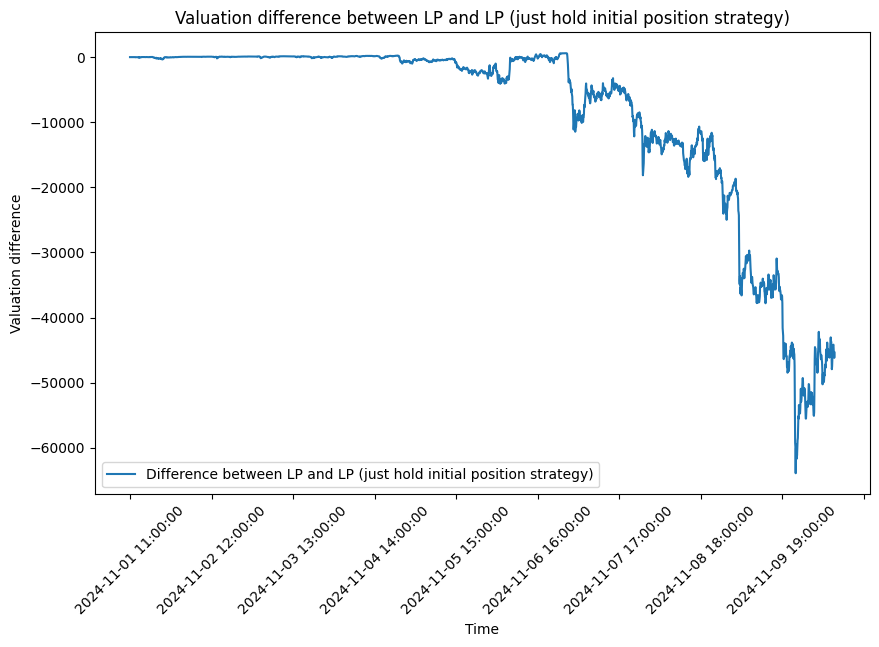

In [8]:
# Plot difference between two lp strategies

lp_valuations_diff = np.array(extract_lp_valuations(simulation_result)) - np.array(extract_lp_only_hold_valuations(simulation_result))

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x=simulation_result.timestamps,
    y=lp_valuations_diff,
    ax=ax,
    label="Difference between LP and LP (just hold initial position strategy)",
)

plt.xlabel("Time")
plt.ylabel("Valuation difference")

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(
    MaxNLocator(nbins=10)
)  # Set to show a maximum of 10 ticks

plt.title("Valuation difference between LP and LP (just hold initial position strategy)")

plt.show()